In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/saikarthik/Desktop/xai /nasdq.csv', index_col=0, parse_dates=True)



In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])



In [5]:
def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])  # Sequence of past 60 days
        y.append(data[i, 0])  # Next day's price
    return np.array(x), np.array(y)

x, y = create_sequences(scaled_data)


In [6]:
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  

model.compile(optimizer='adam', loss='mean_squared_error')


2024-11-13 11:03:24.839023: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-13 11:03:24.839057: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-13 11:03:24.839062: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-13 11:03:24.839094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-13 11:03:24.839110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Step 7: Make predictions
predicted_prices = model.predict(x_test)

# Step 8: Inverse transform the predictions and the true values to original scale
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/10


2024-11-13 11:03:26.077496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-13 11:03:26.293934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-13 11:03:26.356971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-13 11:03:26.492094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/97 [>.............................] - ETA: 1s - loss: 0.0490  

2024-11-13 11:03:26.617795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


97/97 [==============================] - 3s 19ms/step - loss: 0.0035
Epoch 2/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1937e-04
Epoch 3/10
97/97 [==============================] - 2s 19ms/step - loss: 1.2430e-04
Epoch 4/10
97/97 [==============================] - 2s 19ms/step - loss: 1.2127e-04
Epoch 5/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1876e-04
Epoch 6/10
97/97 [==============================] - 2s 18ms/step - loss: 1.1353e-04
Epoch 7/10
97/97 [==============================] - 2s 18ms/step - loss: 1.2118e-04
Epoch 8/10
97/97 [==============================] - 2s 18ms/step - loss: 1.4695e-04
Epoch 9/10
97/97 [==============================] - 2s 19ms/step - loss: 1.1502e-04
Epoch 10/10
 1/25 [>.............................] - ETA: 8s

2024-11-13 11:03:45.066651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-13 11:03:45.132742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-13 11:03:45.178782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 7ms/step


In [9]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_rescaled, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_test_rescaled, predicted_prices)
print(f"R-Squared (R²): {r2}")

mse = mean_squared_error(y_test_rescaled, predicted_prices)
print(f"Mean Squared Error (MSE): {mse}")


Mean Absolute Error (MAE): 1.3929631087823124
R-Squared (R²): 0.9273353051438128
Mean Squared Error (MSE): 3.218565702880533


Root Mean Squared Error: 1.7940361487106475


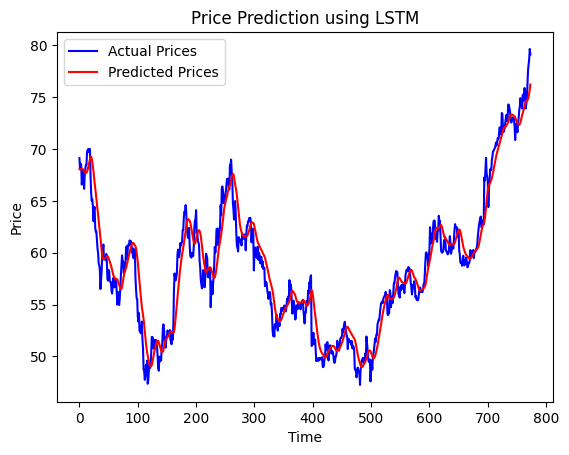

In [10]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_prices))
print(f"Root Mean Squared Error: {rmse}")

# Step 10: Plot the predictions vs. actual values
plt.plot(y_test_rescaled, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [11]:
model.save('lstm_model.h5')  


/Users/saikarthik/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
last_sequence = scaled_data[-60:]  
last_sequence = last_sequence.reshape(1, 60, 1) 

next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)  

print(f"Next day's predicted price: {next_day_prediction[0][0]}")


1/1 [==============================] - 0s 39ms/step
Next day's predicted price: 76.6833724975586


In [13]:
# Predicting the next week's prices (5 days)
predictions_week = []
current_sequence = scaled_data[-60:]  

for _ in range(5): 
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_week.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  # Shift the sequence for next prediction

print("Predicted prices for next week:", predictions_week)


1/1 [==============================] - 0s 13ms/step
Predicted prices for next week: [76.68337, 76.95823, 77.124146, 77.21866, 77.26671]


In [14]:
print(np.mean(predictions_week))

77.05022


In [15]:
# Predicting the next month's prices (20 days)
predictions_month = []
current_sequence = scaled_data[-60:]  

for _ in range(20):  
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_month.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  # Shift the sequence for next prediction

print("Predicted prices for next month:", predictions_month)


1/1 [==============================] - 0s 14ms/step
Predicted prices for next month: [76.68337, 76.95823, 77.124146, 77.21866, 77.26671, 77.28501, 77.28459, 77.27255, 77.25338, 77.22991, 77.203865, 77.176315, 77.1479, 77.119026, 77.08993, 77.060776, 77.03166, 77.00268, 76.97383, 76.9452]


In [16]:
np.mean((predictions_month))

77.11638

In [17]:
predictions_year = []
current_sequence = scaled_data[-60:]  

for _ in range(252): 
    current_sequence = current_sequence.reshape(1, 60, 1)
    next_day_pred = model.predict(current_sequence)
    next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)
    predictions_year.append(next_day_pred_rescaled[0][0])
    current_sequence = np.append(current_sequence[0][1:], next_day_pred)  

print("Predicted prices for next year:", predictions_year)


1/1 [==============================] - 0s 14ms/step
Predicted prices for next year: [76.68337, 76.95823, 77.124146, 77.21866, 77.26671, 77.28501, 77.28459, 77.27255, 77.25338, 77.22991, 77.203865, 77.176315, 77.1479, 77.119026, 77.08993, 77.060776, 77.03166, 77.00268, 76.97383, 76.9452, 76.91678, 76.8886, 76.86068, 76.833015, 76.805626, 76.7785, 76.75164, 76.72506, 76.69873, 76.67266, 76.64685, 76.62131, 76.596, 76.57094, 76.54613, 76.52154, 76.49719, 76.47307, 76.44917, 76.42549, 76.40203, 76.37879, 76.35576, 76.33293, 76.31031, 76.287895, 76.265686, 76.243675, 76.22186, 76.20024, 76.17882, 76.15756, 76.13653, 76.11565, 76.09496, 76.07447, 76.05414, 76.034004, 76.01403, 75.99425, 75.97462, 75.95517, 75.9359, 75.916794, 75.89785, 75.87907, 75.86046, 75.842, 75.82371, 75.80557, 75.78759, 75.76976, 75.75209, 75.73459, 75.71722, 75.7, 75.68293, 75.66599, 75.649216, 75.63258, 75.61609, 75.59974, 75.583534, 75.56745, 75.55153, 75.53571, 75.52004, 75.50452, 75.489105, 75.47383, 75.458694, 75

In [18]:
np.mean((predictions_year))

75.2508

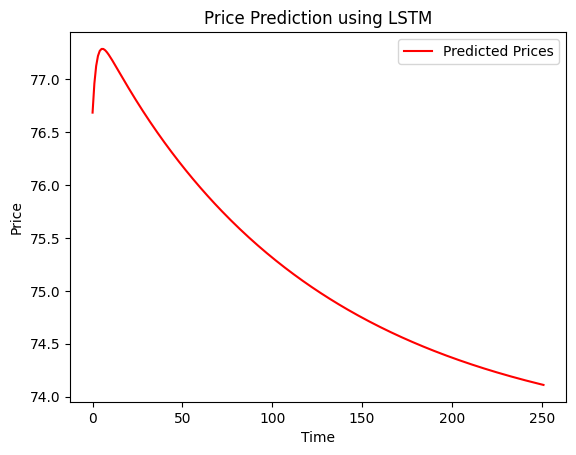

In [22]:
plt.plot(predictions_year, color='red', label='Predicted Prices')
plt.title('Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()